## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Курятников Арсений Дмитриевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

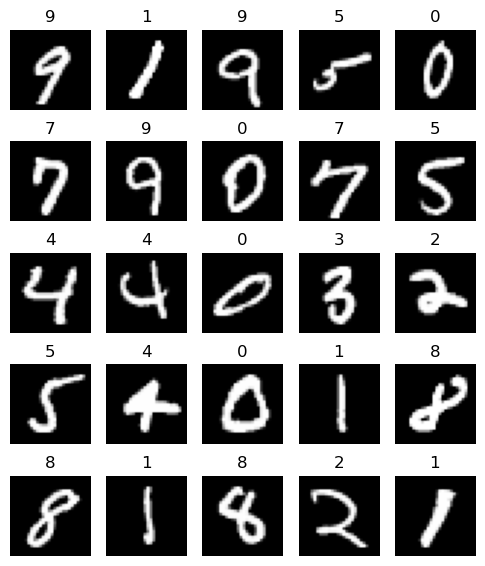

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

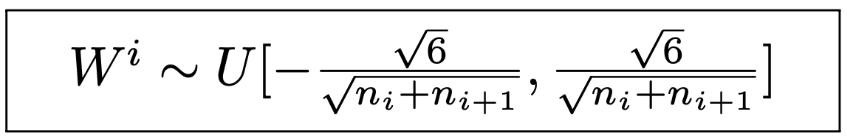

In [9]:
def init_layer_U(layer, a, b):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(a, b)

In [10]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, - np.sqrt(6 / (28 * 28 + 500)), np.sqrt(6 / (28 * 28 + 500)))
init_layer(layer_2, - np.sqrt(6 / 510), np.sqrt(6 / 510))

In [11]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

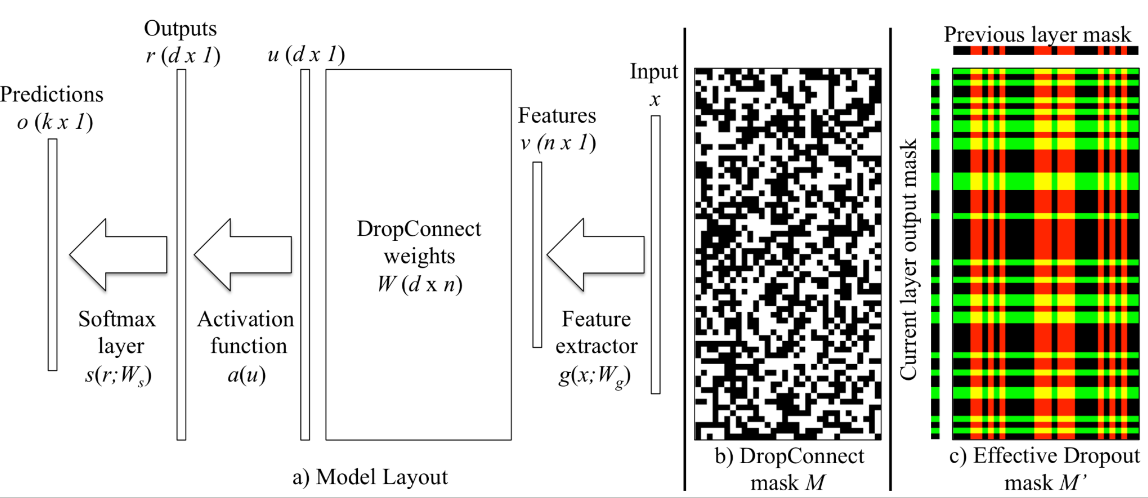

In [12]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.bernoulli(torch.full_like(self.linear.weight, 1 - self.p))
        else:
            mask = torch.ones_like(self.linear.weight)

        mask.requires_grad = False
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [13]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [14]:
layers = [ # 2.2.2
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

In [15]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [16]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295978
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.473206
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.947317
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.769337
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.465410
Test Epoch: 0	Loss: 1.304446
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.479674
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.587902
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.313366
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.328332
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.378145
Test Epoch: 1	Loss: 0.907268
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.333374
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.384236
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.456598
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.334205
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.273429
Test Epoch: 2	Loss: 0.724901
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.225929
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.315996
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.279394
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [17]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

In [18]:
layers = [ # 2.2.1
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

In [19]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [20]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301492
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.101098
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.609210
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.473140
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.559788
Test Epoch: 0	Loss: 0.346047
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.374295
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.385345
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.343185
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.239242
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.174984
Test Epoch: 1	Loss: 0.260516
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.286352
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.254418
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.300949
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.413058
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.196222
Test Epoch: 2	Loss: 0.225351
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.181737
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.240489
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.299078
Train Epoch: 3 [38400/60000 (64%)

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

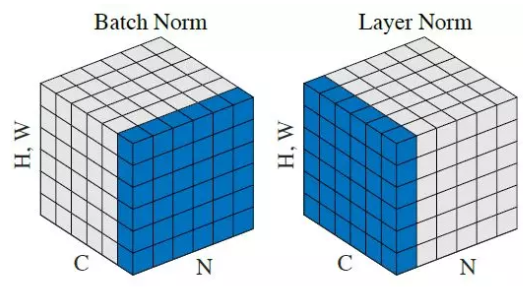

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [37]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + 1e-8)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [38]:
class BatchNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)
        return output

In [39]:
layers = [ # 3.2.1
    nn.Linear(196, 128),
    nn.ReLU(),
    BatchNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    BatchNormalization(),
    nn.Linear(128, 10)
]

In [40]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [41]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.500100
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.206941
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.175482
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.115440
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.166726
Test Epoch: 0	Loss: 0.101059
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.108899
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.072940
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.148133
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.085396
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.036138
Test Epoch: 1	Loss: 0.070880
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.079081
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.045747
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.040185
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.021875
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.100656
Test Epoch: 2	Loss: 0.068456
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.021684
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.044711
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.091036
Train Epoch: 3 [38400/60000 (64%)

In [42]:
layers = [ # 3.2.2
    nn.Linear(196, 128),
    nn.ReLU(),unbiased=False)
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 10)
]

In [43]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [44]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.718625
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.304402
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.240438
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.073610
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.116529
Test Epoch: 0	Loss: 0.104296
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.070251
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.115575
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.047828
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.076651
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.074448
Test Epoch: 1	Loss: 0.076823
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.035863
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.044037
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.119937
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.050108
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.076009
Test Epoch: 2	Loss: 0.066815
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.020194
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.068375
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.050448
Train Epoch: 3 [38400/60000 (64%)